**Load Data**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import warnings
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

In [3]:
train_df.shape

(87554, 188)

In [4]:
test_df.shape

(21892, 188)

In [5]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


In [6]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

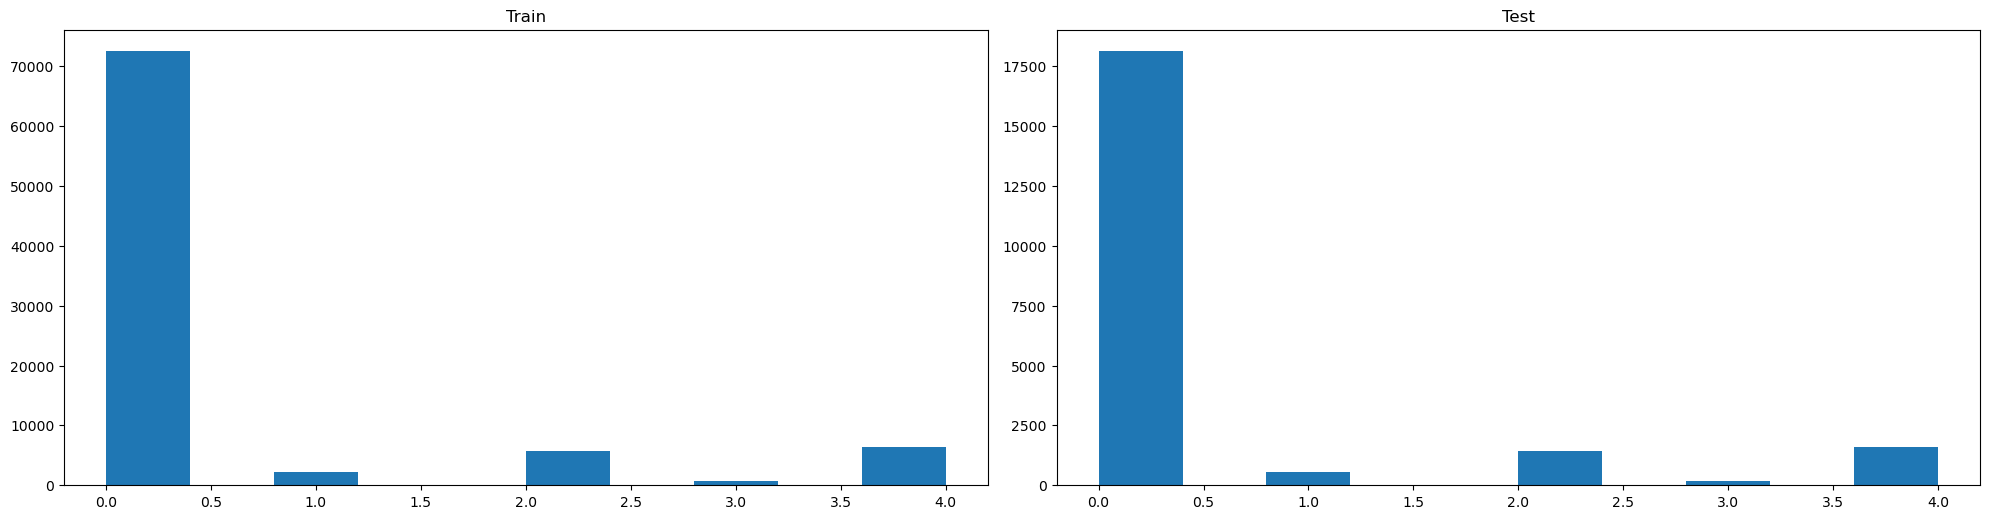

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.hist(train_df[187])
plt.title("Train")

plt.subplot(2,2,2)
plt.hist(test_df[187])
plt.title("Test")

plt.tight_layout()
plt.show()


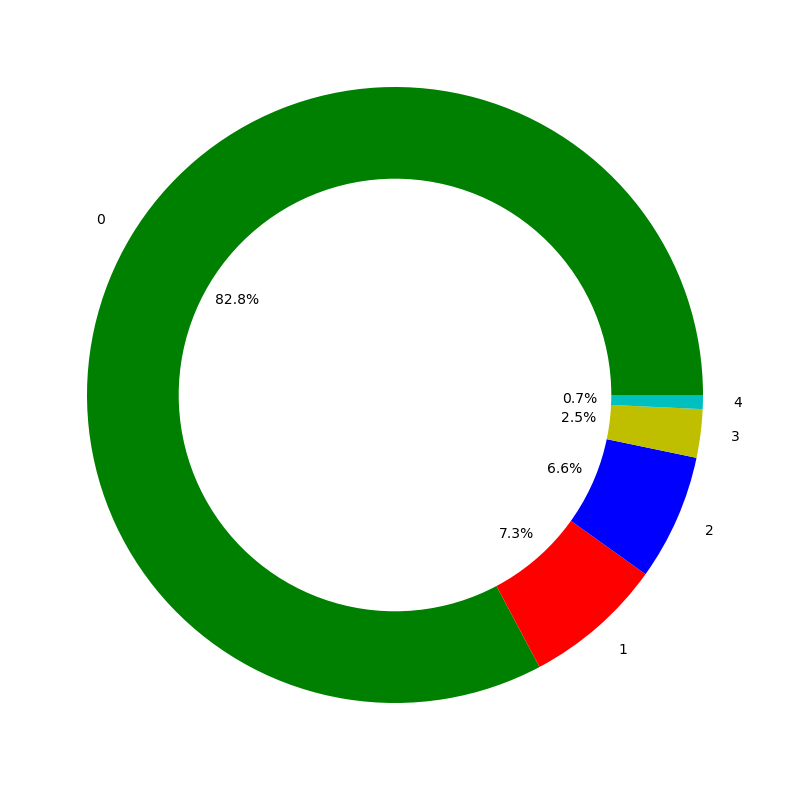

In [8]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['0','1','2','3','4'], colors=['g','r','b','y','c'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [9]:
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    flatten=Flatten()(pool2)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [10]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.title('Model - Loss')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [11]:
model,history=network(X_train,y_train,X_test,y_test)




Epoch 1/40


2737/2737 [==============================] - 11s 4ms/step - loss: 0.1329 - accuracy: 0.9633 - val_loss: 0.1611 - val_accuracy: 0.9576
Epoch 2/40
2737/2737 [==============================] - 9s 3ms/step - loss: 0.0738 - accuracy: 0.9787 - val_loss: 0.0824 - val_accuracy: 0.9775
Epoch 3/40
2737/2737 [==============================] - 9s 3ms/step - loss: 0.0571 - accuracy: 0.9829 - val_loss: 0.0778 - val_accuracy: 0.9803
Epoch 4/40
2737/2737 [==============================] - 9s 3ms/step - loss: 0.0466 - accuracy: 0.9860 - val_loss: 0.0874 - val_accuracy: 0.9763
Epoch 5/40
2737/2737 [==============================] - 9s 3ms/step - loss: 0.0393 - accuracy: 0.9876 - val_loss: 0.0790 - val_accuracy: 0.9792
Epoch 6/40
2737/2737 [==============================] - 9s 3ms/step - loss: 0.0345 - accuracy: 0.9892 - val_loss: 0.0743 - val_accuracy: 0.9815
Epoch 7/40
2737/2737 [==============================] - 9s 3ms/step - loss: 0.0293 - accuracy: 0.9905 - val_loss: 0.0819 - val_acc

Accuracy: 98.15%


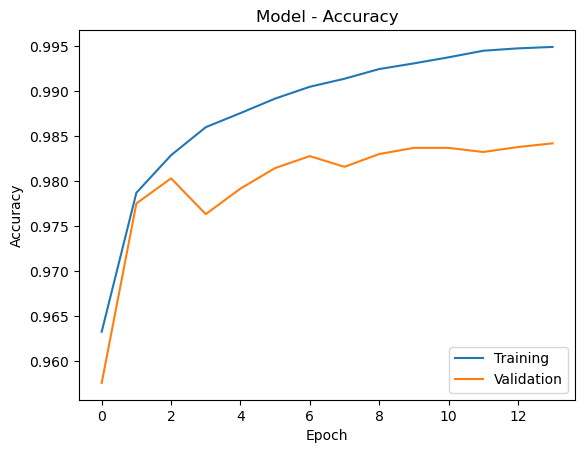

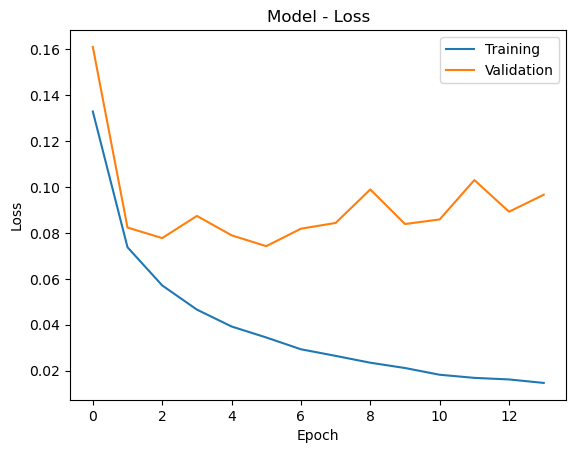

685/685 [==============================] - 1s 1ms/step


In [12]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

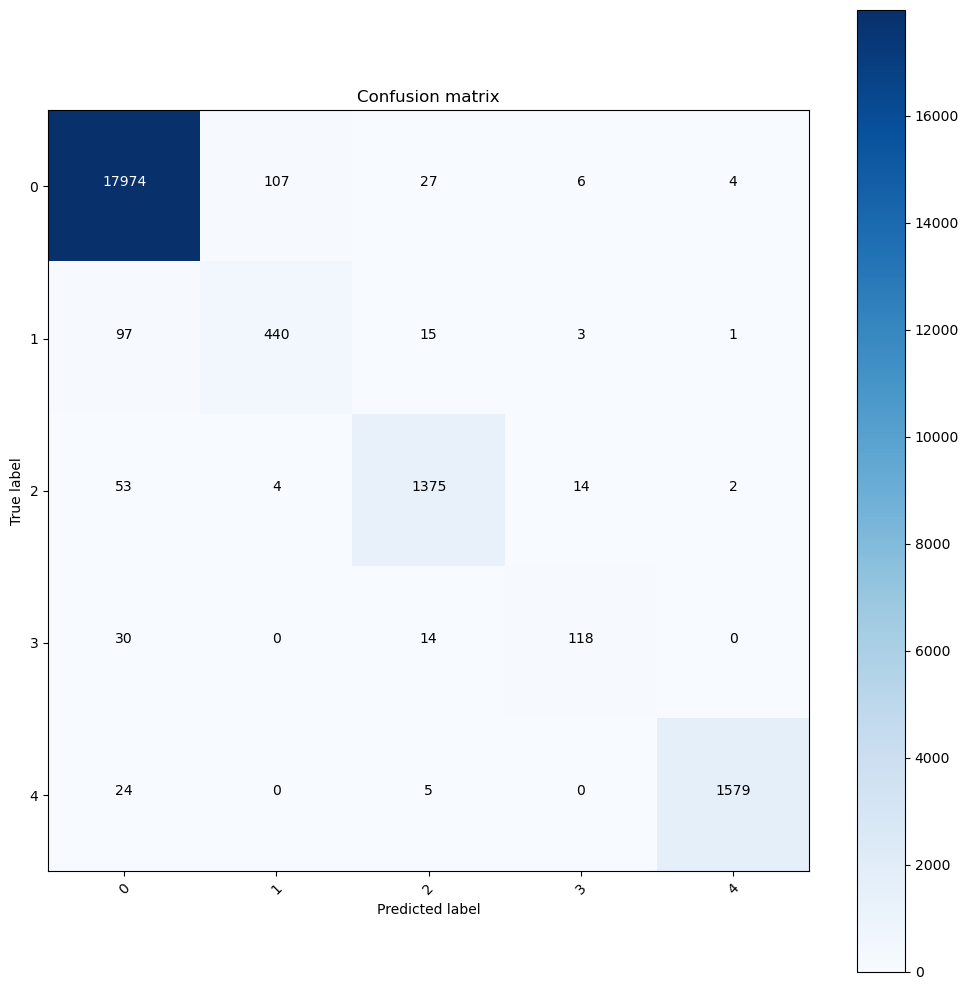

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2', '3', '4'],normalize=False,
                      title='Confusion matrix')

plt.savefig('matrix.png')
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Convert the predictions from categorical to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['0', '1', '2', '3', '4'])

print(report)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.80      0.79      0.79       556
           2       0.96      0.95      0.95      1448
           3       0.84      0.73      0.78       162
           4       1.00      0.98      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.92      0.89      0.90     21892
weighted avg       0.98      0.98      0.98     21892

